# Data architectures

In this lab, we will explore and familiarise with some of the most common data formats for web mapping: GeoJSON and Mbtiles. 

## 3.1 GeoJSON

To get familiar with the format, we will start by creating a GeoJSON file from scratch. Head over to the following website:

<https://geojson.io/>

In there, we will create together a small example to better understand the building blocks of this file format.

<img src=img/geojson.png/ width="80%">

We will pay special attention to the following aspects:

-   Readability.
-   Coordinate system.
-   Ability to add non-spatial information attached to each record.
-   How to save it as a file.

<div class="alert alert-success">

**Excercise**:

Create a GeoJSON file for the following data and save them to separate files:

1.  Your five favourite spots in Liverpool
2.  A polygon of what you consider to be the boundary of the neighbourhood where you live and the city centre of Liverpool. Name each.
3.  A route that captures one of your favorite walks around the Liverpool region

If you are comfortable, upload the files to Microsoft Teams to share them with peers.

</div>

### 3.1.1 GeoJSON in Python

With the files from the exercise at hand, we will learn how to open them in a Python environment. Then, let's begin by importing the necessary libraries; `geojson`is used for handling GeoJSON files.

In [2]:
import geopandas as gpd
import geojson

Now, place the .geojson files you have created in the data folder used in these sessions. As always, the data folder should be stored in the directory where the notebook is running from. For this example, we will assume that the file is called `map.geojson`. We can read the file as:

In [36]:
liverpool = gpd.read_file("data/map.geojson")
liverpool.head()

,geometry
0,POINT (-2.95623 53.39041)
1,"LINESTRING (-2.95561 53.39037, -2.95555 53.389..."
2,"POLYGON ((-2.96760 53.40312, -2.96760 53.40017..."


We can also plot and explore the content of the GeoDataFrame with `Folium`. Folium, which we will see more in detail later on, helps create interactive maps from data stored in `geopandas.GeoDataFrame`.

In [37]:
import folium 

liverpool_centroid = (53.41058,	-2.97794)
# Create a Folium map centered around this point
map = folium.Map(location=liverpool_centroid, zoom_start=13, tiles="CartoDB.DarkMatterNoLabels")

# Add the liverpool data to the map, this will plot each geometry in the GeoDataFrame
folium.GeoJson(liverpool).add_to(map)
map

Once read, the geojson behaves exactly like any GeoDataFrame we have seen so far. We can therefore operate on it and tap into the functionality from `pandas` and `geopandas`. For example, we can and reproject the layer to the to British National Grid.

In [10]:
liverpool_bng.to_crs(crs = "EPSG: 27700", inplace = True)

When we inspected our geojson, we noted that the spatial data is stored in the following format `POINT (-2.977367 53.40753)`. This is called "well known text" (`wkt`) and is a representation that spatial databases like PostGIS use as well. Another way to store spatial data as text for storage or transfer, less (human) readable but more efficient is the "well known blurb" (`wkb`). We can use the `shapely` library to handle the WKT representation of the geometry and then convert it to WKB format.

In [30]:
from shapely import wkt
from shapely.geometry import Point
import shapely.wkb

# Load the WKT representation of the point
wkt_string = "POINT (-2.977367 53.40753)"

# Convert the WKT representation into a Shapely Point object
point = wkt.loads(wkt_string)

# Convert the Point object into WKB format
wkb_data = shapely.wkb.dumps(point)
wkb_data.hex()

'01010000005e8429caa5d107c0c7116bf129b44a40'

<div class="alert alert-success">
    
**Excercise**:
-   Read the `GeoJSON` created for your favorite walks in Liverpool and calculate their length

</div>

Once you are happy with the data as we will hypothetically need it, you can write it out to any other file format supported in `geopandas`. For
example, we can create a Geopackge file with the same information. For this, we can use the function `to_file`. See an example below:

In [ ]:
# Write 'liverpool_bng' to a GeoPackage file
liverpool_bng.to_file("data/liverpool_bng.gpkg", layer="liverpool_bng", driver="GPKG")

## 3.2 Tilesets and `Mbtiles`
In this section we will dive into the concept of tiles to understand why they have been so transformative in the world of web mapping. We have
already seen the usage of tilesets above with `folium` and with `contextily` (although within a static context). We will see that `folium`, integrates different tileset options already.

For this section, let's start by getting the building footprints from OpenStreetMap with `osmnx`

In [38]:
import osmnx as ox
tags = {"building": True} #OSM tags
buildings = ox.features_from_place("Liverpool, UK", tags = tags) 
buildings = buildings.reset_index()
 # sometimes building footprints are represented by Points, let's disregard them
buildings = buildings[(buildings.geometry.geom_type == 'Polygon') | (buildings.geometry.geom_type == 'MultiPolygon')]

<Axes: >

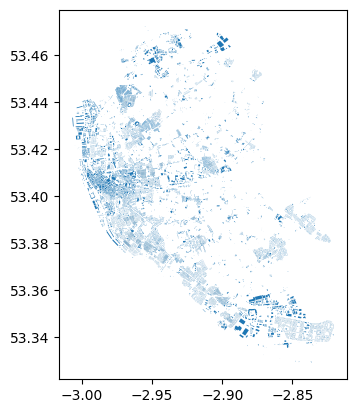

In [35]:
buildings.plot()

Let's save the GeoDataFrame a geojson and call it `buildings_liverpool.geojson`.

In [ ]:
buildings.to_file('data\buildings_liverpool.geojson',  driver='GeoJSON')

Then, register for a MapBox account [here](https://account.mapbox.com/auth/signup/?route-to=%22https%3A%2F%2Faccount.mapbox.com%2Faccess-tokens%2F%22).

### 3.2.1 Generating .mbtiles in Python

In Python, you can use `togeojsontiles` to make a dynamic `.mbtiles` files. This is useful to visualize large data appropriately at any zoom level.


In [43]:
from togeojsontiles import geojson_to_mbtiles

# Convert GeoJSON to .mbtiles
buildings_liverpool.geojson_to_mbtiles(
           output_mbtiles='data/buildings_liverpool.mbtiles',
           layer_name='buildings_liverpool')
    filepaths=['./data/test1.geojson', './data/test2.geojson'],
    tippecanoe_dir=TIPPECANOE_DIR,
    mbtiles_file='out.mbtiles',
    maxzoom=14

NameError: name 'buildings_liverpool' is not defined

Uploading to **Mapbox Studio**: After creating the `.mbtiles` file, you can upload it *manually* to Mapbox Studio:

- Navigate to Mapbox Studio.
- Start a New Style and chose a template (Monochrome, blank etc.)
  
<img src=img/mapboxstyles.png/ width="80%">

- Upload the .mbtiles file and style it according to your requirements
  
<img src=img/mapbox_upload.png/ width="80%">

- It should look like a nicer version of this:
  
<img src=img/mapbox_building_studio.png/ width="80%">

Or through *scripting* with Mapbox's Uploads API.

In [ ]:
import requests
import os

# Define your Mapbox token
mapbox_token = "pk.eyJ1IjoicGlldHJvc3RlZmFuaWUiLCJhIjoiY2xkeGJtb3hkMGN4azNxb2E4cGRnbDhxayJ9.VaEiB7qvRk8BbFlihawZ1w"

# Endpoint for Mapbox Tiling Service uploads
url = 'https://api.mapbox.com/uploads/v1/mapbox'

# Path to your .mbtiles file
mbtiles_file_path = "data/file.mbtiles'

# Prepare the headers
headers = {
    'Authorization': f'Bearer {MAPBOX_ACCESS_TOKEN}',
    'Content-Type': 'application/json'
}

# Prepare the data for the POST request
with open(mbtiles_file_path, 'rb') as file:
    files = {'file': file}
    response = requests.post(url, headers=headers, files=files)

# Check the response
if response.status_code == 200:
    print("Upload initiated successfully.")
    print(response.json())
else:
    print("Failed to initiate upload.")
    print(response.text)

### Visualizing in Python
#### Visualizing with Folium:

In [ ]:
# Create a Folium map centered at a specific location
m = folium.Map(location=[53.406872, -2.973286], zoom_start=10,
               tiles='https://api.mapbox.com/styles/v1/pietrostefanie/cle4dgs2o002d01tft37b5ndg/tiles/256/{z}/{x}/{y}?access_token=pk.eyJ1IjoicGlldHJvc3RlZmFuaWUiLCJhIjoiY2xkeGJtb3hkMGN4azNxb2E4cGRnbDhxayJ9.VaEiB7qvRk8BbFlihawZ1w',
               attr='Mapbox')

# Display the map
m


In [ ]:
Visualizing with Pydeck:

In [ ]:
import pydeck as pdk


# Define your Mapbox token
mapbox_token = "pk.eyJ1IjoicGlldHJvc3RlZmFuaWUiLCJhIjoiY2xkeGJtb3hkMGN4azNxb2E4cGRnbDhxayJ9.VaEiB7qvRk8BbFlihawZ1w"

# Create a Pydeck map using the Mapbox layer
layer = pdk.Layer(
    'MapboxLayer',
    id='mapbox',
    data='mapbox://styles/username/cle4dgs2o002d01tft37b5ndg'  # Replace with your styled layer
)

view_state = pdk.ViewState(latitude=liverpool_centroid[0], longitude=liverpool_centroid[1], zoom=10)
r = pdk.Deck(layers=[layer], initial_view_state=view_state, mapbox_key=mapbox_token)
r.show()